In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from sklearn.linear_model import LinearRegression
from IPython.display import HTML, display
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Functions which can be used 

In [2]:
# define functions to use
def f_gauss(x, t=0):
#     return -0.5 * np.cos(2 * np.pi * (x-t)) + .5
    func = np.exp(10*np.sin(np.pi * (x-t))**2) - 1
    return func / np.max(func)

# Functions for time-stepping
Using numerical method and machine learning method

In [91]:
def num_step(ys, dt, nsteps, all_steps=True):
    y_next = np.zeros((len(ys), nsteps+1))
    y_next[:,0] = ys
    dx = 1/(len(ys)-1)
    A = np.diag(np.ones(len(ys)-1)*dt/dx, -1) + np.eye(len(ys))*(1 - dt / dx)
    for i in range(nsteps):
        y_next[:,i+1] = A @ y_next[:,i]
        y_next[0,i+1] = y_next[-1,i+1]
    if all_steps:
        return y_next
    else:
        return y_next[:,-1]
    return y_next

def ml_step(ys, dt, nsteps, params, stencil, all_steps=True):
    y_next = np.zeros((len(ys), nsteps+1))
    y_next[:,0] = ys
    dx = 1/(len(ys)-1)
    A = make_matrix(params, nx, stencil)
    for i in range(nsteps):
        y_next[:,i+1] = A @ y_next[:,i]
        y_next[0,i+1] = y_next[-1,i+1]
    if all_steps:
        return y_next
    else:
        return y_next[:,-1]
    
def make_matrix(params, nx, stencil):
    A = np.eye(nx)*params[0]
    for i in range(1,len(params)):
        A += np.diag(np.ones(nx-i)*params[i], k=-i)
    if len(params)+1 == stencil:
        A += np.diag(np.ones(nx-stencil)*(1-np.sum(params)), k=-stencil)
    return A

# Cost function to minimize for ML model
L2 loss

In [107]:
def ml_loss(params, data, rollout, stencil, nx, dt):    
    # mse for each rollout period (1,2,...,rollout)
    mse = np.zeros(rollout)
    n = np.zeros(rollout) # number of data points per rollout period
     
    # Iterate over each time step
    for ti in range(len(data[0])-1):        
        nsteps = min(len(data[0])-1-ti, rollout)
        pred = ml_step(data[:,ti], dt, nsteps, params, stencil)
        mse[:nsteps] += np.sum((pred[1:,1:] - data[1:,ti+1:ti+1+nsteps])**2, axis=0)
        n[:nsteps] += nx-1 # don't calculate loss from repeated point in loss
    mse /= n
    
    # Equally weight the losses across the different rollout periods
    mse = np.mean(mse)
    return mse
        
        
def train_ml(dt, dx, nsteps, rollout, stencil, f, print_mes=True, params0=None):
    x = np.arange(0,1+dx/2, dx)
    t = np.arange(0,dt*nsteps+dt/2,dt)
    X, T = np.meshgrid(x, t, indexing='ij')
    data_train = f(X, T)
    
    if not params0:
        params0 = np.ones(stencil)/stencil
    result = minimize(ml_loss, params0, args=(data_train, rollout, stencil, nx, dt), method='BFGS')
    params = result.x
    if print_mes:
        print('Success! Learned params:', params)
        print('Numerical a, b:', (1 - dt / dx), dt/dx) 
    return params
    

# Train the ML model

In [108]:
# Define training parameters
dt = 0.001
nsteps = 50
rollout = 10 # number of time steps forward to use in training
dx = 0.01
nx = int(1/dx + 1)
stencil = 2 # stencil width (upwind)

# Define the function
f = f_gauss

# train the model
params = train_ml(dt, dx, nsteps, rollout, stencil, f, print_mes=True)

Success! Learned params: [0.90037972 0.10003696]
Numerical a, b: 0.9 0.1


# Stability of learned matrix

# Compare model results after dt*nsteps time

In [109]:
num_steps_test = 100
ml_result = ml_step(f(x), dt, num_steps_test, params, stencil, all_steps=False)
num_result = num_step(f(x), dt, num_steps_test, all_steps=False)
data_result = f(x, dt*num_steps_test)

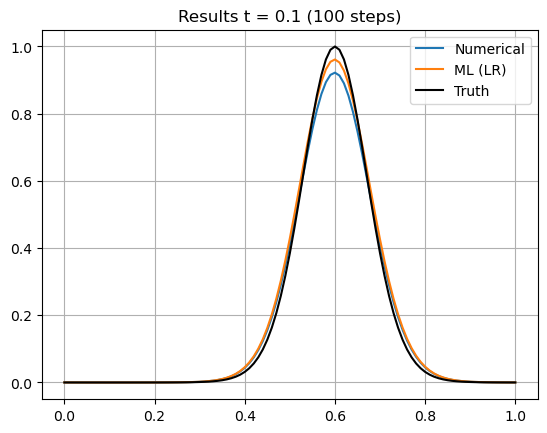

In [110]:
plt.plot(x, num_result, label='Numerical')
plt.plot(x, ml_result, label='ML (LR)')
plt.plot(x, data_result, c='black', label='Truth')
plt.title(f'Results t = {dt*num_steps_test} ({num_steps_test} steps)')
plt.legend()
plt.grid()

# Plot MSE with time

In [111]:
num_steps_test = int(5/dt)
ml_result = ml_step(f(x), dt, num_steps_test, params, stencil)
num_result = num_step(f(x), dt, num_steps_test)
t = np.arange(0,dt*num_steps_test+dt/2,dt)
X, T = np.meshgrid(x, t, indexing='ij')
data_result = f(X, T)

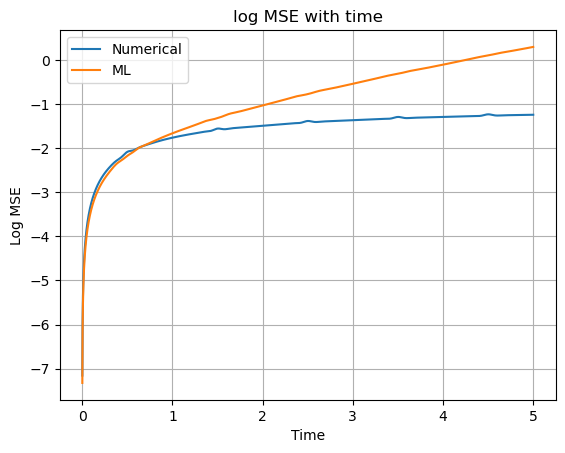

In [112]:
plt.plot(t, np.log10(np.mean((num_result-data_result)**2, axis=0)), label='Numerical')

plt.plot(t, np.log10(np.mean((ml_result-data_result)**2, axis=0)), label='ML')
plt.title(f'log MSE with time')
plt.xlabel("Time")
plt.ylabel("Log MSE")
plt.legend()
plt.grid()

# Animate Evolution of System

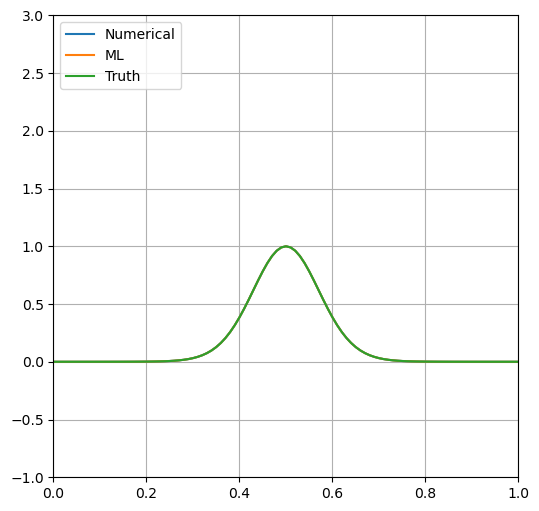

In [113]:
# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(6,6))

# Plot the initial frame. 
line1, = ax.plot(x, num_result[:,0], label='Numerical')
line2, = ax.plot(x, ml_result[:,0], label='ML')
line3, = ax.plot(x, data_result[:,0], label='Truth')
ax.legend(loc='upper left')
ax.set_ylim([-1,3])
ax.grid()
ax.set_xlim([0,1])

skip=50

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    line1.set_data(x, num_result[:,frame*skip])
    line2.set_data(x, ml_result[:,frame*skip])
    line3.set_data(x, data_result[:,frame*skip])
    ax.set_title("Time = " + str(np.round(dt*frame*skip, 4)) + f", Step = {frame*4}")


# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=(len(num_result[0])-skip)//skip,       # Could also be iterable or list
    interval=dt*1000*skip     # ms between frames
)

In [114]:
HTML(ani.to_jshtml())